<a href="https://colab.research.google.com/github/Felipanjos/a3_ia_2022.2/blob/main/Projeto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.2 Requisitos da Análise do problema

### A. Entendimento do Problema:

#### a. Especificação do objetivo geral e dos objetivos específicos

Para esse projeto utilizamos os conhecimentos adquiridos ao longo da nossa disciplina, para criar uma Maquina Preditiva com o objetivo de estimar quantos transistores existem em um determinado CPU. Sabemos que mais transistores em nossa CPU significa mais paralelismo para as tarefas do mesmo, permitindo que essas tarefas sejam finalizadas mais rapidamente. Historicamente vimos que os processadores se tornaram cada vez mais poderosos e junto a isso podemos perceber que o numero de transistores aumentou significativamente. 

## B. Enquadramento do Problema:

### a. Especificação do tipo de problema: Quanto à Supervisão, Quanto à Tarefa, Quanto ao Modo;

Para esse projeto utilizamos os conhecimentos adquiridos ao longo da nossa disciplina, para criar uma Maquina Preditiva com o objetivo de estimar quantos transistores existem em um determinado CPU. Sabemos que mais transistores em nossa CPU significa mais paralelismo para as tarefas do mesmo, permitindo que essas tarefas sejam finalizadas mais rapidamente. Historicamente vimos que os processadores se tornaram cada vez mais poderosos e junto a isso podemos perceber que o numero de transistores aumentou significativamente.


b. Especificação das Medidas de Desempenho (para Classificação ou Regressão)


Como metódos de desempenho, os principais utilizados no nosso projeto, se tratam de acurácia para a Classicação e erro quadrático médio para Regressão, esses metódos, são extremamente importantes, pois é através deles que é possível observar o quão precisas estão sendo as predições realizadas pela máquina, por serem duas formas diferentes de Aprendizado de máquina supervisionado, cada um possui seu próprio método de desempenho, para a classificação usaremos o principal citado anteriormente, acurácia, se trata de um indicador da performance geral do modelo, contando quantas classificações foram feitas corretamente, para ser calculado, se torna necessário utilizar a Matriz de confusão, identificando os verdadeiros positivos, falso negativos, falso positivos e verdadeiros negativos, através desses dados é possível montar a Matriz e utilizar a formúla VP+VN/VP+VN+FP+FN para assim medir a acurácia do modelo, já para a regressão utilizaremos o erro quadrático médio, esse método carrega como objetivo encontrar a diferença dos valores iniciais com os valores preditos, quanto mais alta a diferença, maior o problema do modelo, pois os valores encontrados não estão sendo precisos, essa média é calculada através da diferença do valor predito para o valor real, o resultado é elevado ao quadrado, fazendo isso para todos os pontos, como já dito, quanto maior o resultado, mais pobre estão sendo as predições.

# 2.3 Requisitos da Análise de Dados:

In [58]:
import pandas as pd
import numpy as np
import random
import string
import sklearn
from itertools import groupby

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as sts

In [22]:
df = pd.read_csv('chip_dataset.csv', index_col=[0])
df.drop('FP16 GFLOPS', axis=1, inplace=True)
df.drop('FP32 GFLOPS', axis=1, inplace=True)
df.drop('FP64 GFLOPS', axis=1, inplace=True)
vendors = list(np.unique(df['Vendor']))

In [23]:
num_attribs = list(df.describe().columns)
cat_attribs = ['Vendor']

In [24]:
df.head()

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD


### B. Divisão

##### a) Amostragem estratificada em Conjunto de Treinamento e Conjunto de Teste

In [25]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [26]:
ranges = [0, df['Transistors (million)'].describe()['25%'], 500, 1000, 2000, 6000, 15000, 30000, np.inf]
tiers = ['F', 'E', 'D', 'C', 'B', 'A', 'S', 'S+']

df['Rank'] = pd.cut(df['Transistors (million)'], bins = ranges, labels = tiers)

In [27]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df, df['Rank']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [28]:
def amostragem_estratificada(test_set):
    return (test_set['Rank'].value_counts() / len(test_set))*100    

In [29]:
amostragem_estratificada(strat_test_set)

F     24.963504
C     19.708029
B     17.226277
E     15.328467
D     14.598540
A      6.131387
S      1.751825
S+     0.291971
Name: Rank, dtype: float64

In [30]:
strat_train_set.drop(columns=['Rank'], inplace=True)
strat_test_set.drop(columns=['Rank'], inplace=True)
cpu = strat_train_set.drop('Transistors (million)', axis=1)

### C. Exploração 

##### a) Visualização dos Dados com gráficos de dispersão e histograma

In [31]:
df['Release Date'] = pd.to_datetime(df['Release Date'])

<AxesSubplot: >

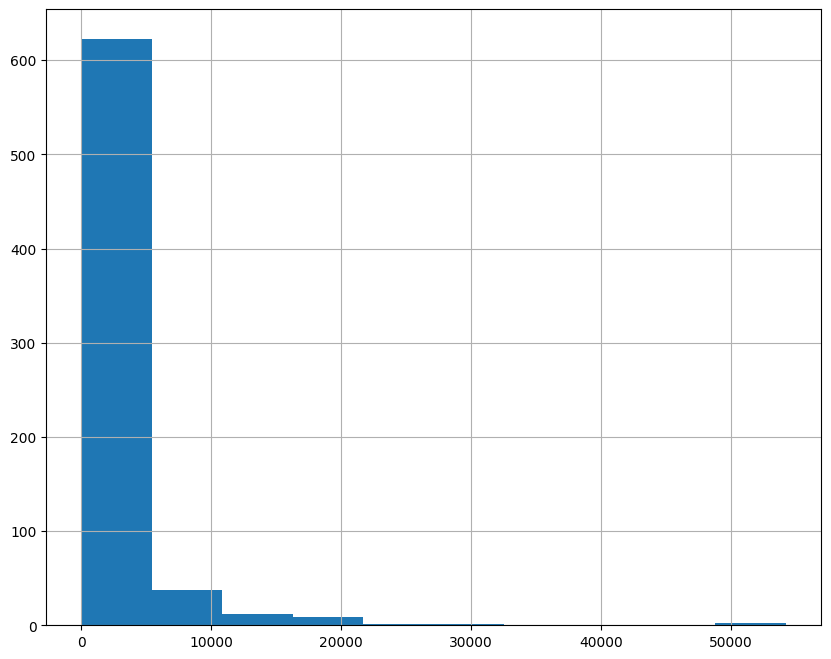

In [32]:
# ampliar escala 
strat_test_set['Transistors (million)'].hist(figsize=(10, 8))

<AxesSubplot: >

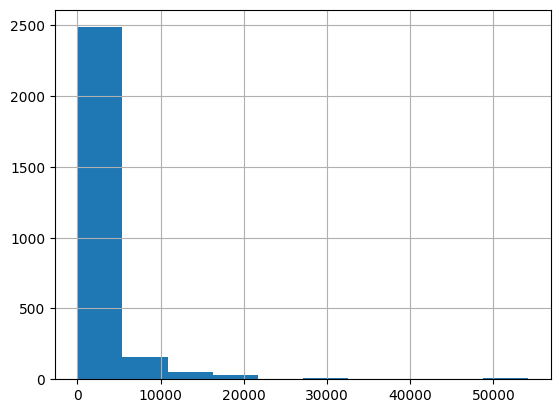

In [33]:
strat_train_set['Transistors (million)'].hist()

<AxesSubplot: xlabel='Release Date', ylabel='Transistors (million)'>

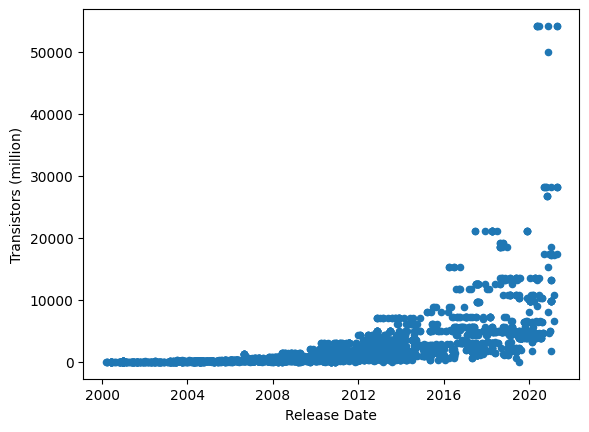

In [34]:
df.plot(kind='scatter', x='Release Date', y='Transistors (million)')

##### b. Levantamento de hipóteses sobre as distribuições dos dados


transistores influenciado por TDP x Die Size

##### c. Busca de correlações (Coeficientes de correlação)

Nesta abordagem inicial do projeto, buscamos conectar o número de transistores com o sua Potência térmica máxima (TDP) e o tamanho de sua matriz (Die size) devido a  avaliação positiva dos coeficientes de relação e a sua lógica primordial, quanto mais transistores normalmente é apresentada uma TDP mais elevada e uma matriz maior.

In [35]:
df['Release Date'] = pd.to_numeric(df['Release Date'])

##### Basearemos a análise das valueelações na coluna Transistors (million), que é o nosso objeto de predição

In [36]:
for value in df.corr()['Transistors (million)']:
    print(value)

-0.002568951085001034
-0.3977453283926615
0.46970179480450375
0.6402633611101106
1.0
-0.04411544348939104


C:\Users\anjos\AppData\Local\Temp\ipykernel_23840\3423880030.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  for value in df.corr()['Transistors (million)']:


In [37]:
colunas_para_calculo = ['Release Date'] + num_attribs
print('Coeficiente de correlação de Pearson entre a coluna Transistors (million) e:')

coor_dict = {}
r_list = []

for value in df.corr()['Transistors (million)']:
    if value == 1:
        r = 'relação linear perfeita e positiva'
    elif value == 0:
        r = 'inexistência linear'
    elif value == -1:
        r = 'relação linear perfeita e negativa'
    elif value > 0:
        r = 'relação linear positiva'
    elif value < 0:
        r = 'relação linear negativa'

    r_list.append(r)

print(df.corr(method='pearson', min_periods=1)['Transistors (million)'], '\n')

count = 0
for col in colunas_para_calculo: 
    coor_dict[col] = r_list[count]
    print(f'{col}: {coor_dict[col]}')
    count += 1


Coeficiente de correlação de Pearson entre a coluna Transistors (million) e:
Release Date            -0.002569
Process Size (nm)       -0.397745
TDP (W)                  0.469702
Die Size (mm^2)          0.640263
Transistors (million)    1.000000
Freq (MHz)              -0.044115
Name: Transistors (million), dtype: float64 

Release Date: relação linear negativa
Process Size (nm): relação linear negativa
TDP (W): relação linear positiva
Die Size (mm^2): relação linear positiva
Transistors (million): relação linear perfeita e positiva
Freq (MHz): relação linear negativa


C:\Users\anjos\AppData\Local\Temp\ipykernel_23840\473720730.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  for value in df.corr()['Transistors (million)']:
C:\Users\anjos\AppData\Local\Temp\ipykernel_23840\473720730.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr(method='pearson', min_periods=1)['Transistors (million)'], '\n')


### D. Preparação

##### a) Selecionando 10% das colunas

In [38]:
qtd_colunas = len(df.columns)
p_colunas = round(qtd_colunas * 10 / 100)
coluna_aleatoria = df.sample(n=p_colunas, axis='columns', random_state=1).keys()[0]
colunas_numericas = df.describe().columns
colunas_categoricas = df.describe(exclude=np.number).columns
coluna_aleatoria # escolhendo uma coluna aleatoriamente

'Release Date'

##### a) Selecionando 3% dos dados

In [39]:
len(df)

3422

In [40]:
p_3 = round(df.shape[0] * 3 / 100)
p_3

103

##### a) Excluindo 3% dos dados aleatoriamente

In [41]:
reg_excluidos = df.sample(n=p_3)
reg_exc_index = reg_excluidos.index.array
df.loc[reg_exc_index, coluna_aleatoria] = np.nan

##### a) Alterando 3% dos dados aleatoriamente

In [42]:
def gerar_string_aleatoria():
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters) for i in range(10)) 

def gerar_numero_aleatorio():
  return random.randint(0, 999)

In [43]:
# listando indexes que sofreram alteração na coluna aleatória
df_selecao_nao_nulo = df[~df[coluna_aleatoria].isnull()]
reg_alterados = df_selecao_nao_nulo.sample(n=p_3)
reg_alter_index = reg_alterados.index.array

In [44]:
if coluna_aleatoria in colunas_numericas:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_numero_aleatorio()
else:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_string_aleatoria()

In [45]:
# listando alterações
count = 0
for index in reg_alter_index:
    print(df[coluna_aleatoria][index])
    count += 1
    if count == 10:
        break

293.0
334.0
904.0
871.0
780.0
798.0
882.0
259.0
919.0
838.0


#### b) Limpeza dos dados

i. Codificação One-Hot

In [46]:
encoder = OneHotEncoder()
onehot_encoded_df = pd.DataFrame(encoder.fit_transform(df[['Vendor']]).toarray())
onehot_encoded_df.columns = vendors

onehot_encoded_df = df.join(onehot_encoded_df)
onehot_encoded_df.drop('Vendor', axis=1, inplace=True)
onehot_encoded_df

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Rank,AMD,ATI,Intel,NVIDIA,Other
0,AMD Athlon 64 3500+,CPU,1.171930e+18,65.0,45.0,77.0,122.0,2200.0,Unknown,F,1.0,0.0,0.0,0.0,0.0
1,AMD Athlon 200GE,CPU,1.536192e+18,14.0,35.0,192.0,4800.0,3200.0,Unknown,B,1.0,0.0,0.0,0.0,0.0
2,Intel Xeon E5-2603 v2,CPU,1.377994e+18,22.0,80.0,160.0,1400.0,1800.0,Intel,C,0.0,0.0,1.0,0.0,0.0
3,AMD Phenom II X4 980 BE,CPU,1.304381e+18,45.0,125.0,258.0,758.0,3700.0,Unknown,D,1.0,0.0,0.0,0.0,0.0
4,Intel Xeon E5-2470 v2,CPU,1.377994e+18,22.0,95.0,160.0,1400.0,2400.0,Intel,C,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417,ATI FirePro V7800,GPU,1.272240e+18,40.0,150.0,334.0,2154.0,700.0,TSMC,B,0.0,1.0,0.0,0.0,0.0
3418,NVIDIA Tegra 3 GPU,GPU,1.320797e+18,40.0,20.0,80.0,10.0,416.0,TSMC,F,0.0,0.0,0.0,1.0,0.0
3419,NVIDIA Playstation 3 GPU 28nm,GPU,1.370218e+18,28.0,21.0,68.0,302.0,550.0,Sony,E,0.0,0.0,0.0,1.0,0.0
3420,NVIDIA Quadro 3000M,GPU,1.298333e+18,40.0,75.0,332.0,1950.0,450.0,TSMC,C,0.0,0.0,0.0,1.0,0.0


ii. Estratégia para dados numéricos ausentes - mediana geral

In [47]:
df.describe()

,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
count,3.319000e+03,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000
mean,1.086335e+18,53.048510,83.740795,200.003799,2163.295441,1507.964641
std,1.341228e+18,41.146049,78.683153,130.795697,4324.171974,1012.767189
min,-9.223372e+18,7.000000,1.000000,1.000000,10.000000,100.000000
25%,1.162339e+18,28.000000,35.000000,111.000000,223.250000,650.000000
50%,1.286755e+18,40.000000,65.000000,160.000000,731.000000,1120.000000
75%,1.381190e+18,65.000000,100.000000,246.000000,2080.000000,2333.000000
max,1.618186e+18,250.000000,900.000000,826.000000,54200.000000,4700.000000


In [48]:
sts.median(df['Transistors (million)'])

731.0

A atribuição da mediana geral foi utilizada para lidar com os valores nulos das colunas em que existiam, pelos seguintes motivos:


Utilizaremos a coluna 'Transistors (million)' como referência por acreditarmos que se trata da coluna principal do dataset.

*   A remoção dos valores nulos do conjunto levaria à retirada de 29.1% dos dados, pouco mais de 1/4 do dataset original
*   Pela forte presença de outliers no dataset, o uso da média para atribuição de dados ausentes não seria uma boa opção. A média da coluna 'Transistors (million)'     seria aproximadamente 2151 milhões.
*   O treinamento de um preditor geraria esforço adicional e sairia do foco da entrega, então utilizamos uma estratégia mais simples para tratar dessa questão.
*   Por isso, escolhemos o uso da mediana. Para a coluna 'Transistorts (millions)' a mediana é 731 milhões, praticamente 3 vezes menos do que a média. A partir disso, obtemos o valor central do dataset, que sofre menos com o impacto dos outliers.


iii. Escalonamento de características: Padronização e iv. Pipeline transformadora

In [49]:
num_attribs = list(cpu.describe(include=np.number))

In [50]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),        
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs),
    ])

In [51]:
cpu

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Freq (MHz),Foundry,Vendor
2038,AMD Radeon HD 6770 Green Edition,GPU,2013-04-19,40.0,86.0,166.0,700.0,TSMC,AMD
3008,NVIDIA GeForce FX 5700,GPU,2003-10-23,130.0,25.0,133.0,425.0,TSMC,NVIDIA
1695,NVIDIA GeForce 315 OEM,GPU,2010-03-31,40.0,33.0,100.0,475.0,TSMC,NVIDIA
974,Intel Core 2 Quad Q6700,CPU,2007-04-20,65.0,95.0,143.0,2666.0,Intel,Intel
1068,AMD A6-9500E,CPU,2017-07-27,28.0,35.0,246.0,3000.0,Unknown,AMD
...,...,...,...,...,...,...,...,...,...
1161,Intel Xeon 7130N,CPU,2006-08-27,65.0,150.0,435.0,3166.0,Intel,Intel
376,Intel Pentium 4-M 1.60,CPU,2002-03-04,130.0,30.0,131.0,1600.0,Intel,Intel
1543,Intel Xeon E3-1275,GPU,2011-04-03,32.0,95.0,216.0,100.0,Intel,Intel
1708,NVIDIA GeForce 315M,GPU,2011-01-05,40.0,14.0,57.0,606.0,TSMC,NVIDIA


In [52]:
cpu_prepared = full_pipeline.fit_transform(cpu)

Utilizando a full_pipeline, aplicamos
*   Codificação One-Hot para dados categóricos com mais de duas categorias (escolhemos a coluna 'Vendor')
*   Atribuição da mediana geral para os dados numéricos ausentes
*   Escalonamento de caretísticas: Padronização
*   Pipeline transformadora utilizando codificaçõa one hot, atribuição de mediana e padronização


In [53]:
cpu_prepared

array([[-0.31607773,  0.02090371, -0.26263445, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.87159933, -0.74244298, -0.5165892 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.31607773, -0.64233194, -0.77054396, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.51053791,  0.13352863,  0.12214549, ...,  1.        ,
         0.        ,  0.        ],
       [-0.31607773, -0.88009566, -1.1014547 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.75361314, -0.05417957, -0.30880804, ...,  1.        ,
         0.        ,  0.        ]])

##### Treinamento do modelo - Regressão Linear

In [86]:
cpu_labels = strat_train_set['Transistors (million)'].copy()
x = df[['Transistors (million)']]
y = df[['Die Size (mm^2)']]

lin_reg = LinearRegression()
lin_reg.fit(x, y)

LinearRegression()

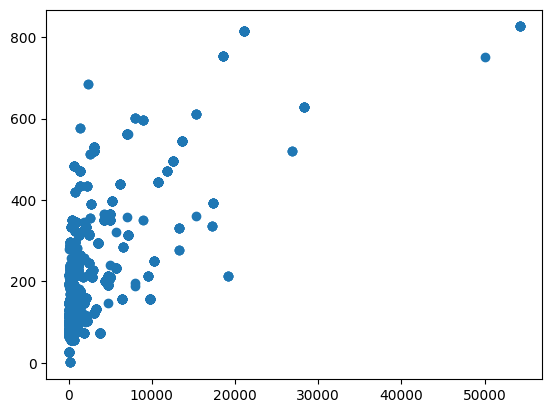

In [87]:
plt.scatter(x, y)

In [88]:
c_angular = lin_reg.coef_
c_linear = lin_reg.intercept_

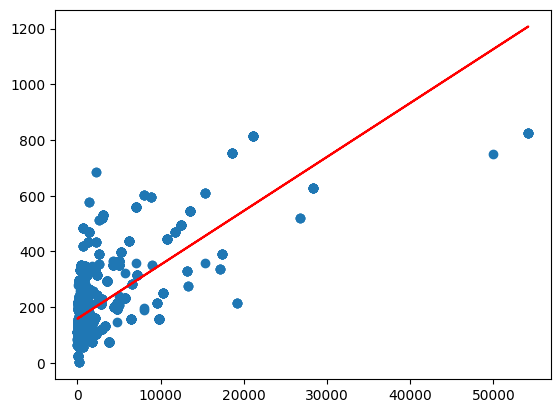

In [103]:
plt.scatter(x, y)
plt.plot(x, c_linear + c_angular * x, color='red')
plt.show()

In [104]:
from sklearn.metrics import mean_squared_error

cpu_predictions = lin_reg.predict(cpu_prepared)
lin_rmse = mean_squared_error(cpu_labels, cpu_predictions, squared=False)

C:\Users\anjos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 9 features, but LinearRegression is expecting 1 features as input.

In [56]:
cpu_predictions

array([ 2239.17928815, -1256.94052508,   845.05035726, ...,
        2844.59120132,    29.77466634,  1867.84899323])

In [57]:
round(lin_rmse, 2)

3074.63

# 2.4 Requisitos da Construção dos Modelos e Aprendizado de Máquina 

### Seleção dos Modelos